# Tiling masks

In [13]:
import numpy as np
import cv2
import json
import os
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import rasterio

# Function to create a mask based on the coordinates of a polygon
def create_mask(image_shape, polygon):
    mask = np.zeros(image_shape, dtype=np.uint8)
    exterior_coords = list(polygon.exterior.coords)
    exterior_coords = [(int(x), int(y)) for x, y in exterior_coords]
    cv2.fillPoly(mask, [np.array(exterior_coords)], color=255)
    return mask

# Load the large satellite image
image = rasterio.open('../data/OpenDataDC_Orthophoto_2021_JPEG2000/DCOCTO-2021.jp2')

# Load the GeoJSON file with road coordinates
with open('../data/Roads.geojson') as file:
    data = json.load(file)

# Extract the road polygons from the GeoJSON file
road_polygons = []
for feature in data['features']:
    if feature['properties']['DESCRIPTION'] == 'Road':
        coordinates = feature['geometry']['coordinates']
        polygon = Polygon([coordinates])
        road_polygons.append(polygon)

# Determine the number of tiles in each dimension
tile_size = 1024
image_height, image_width = image.shape
num_tiles_x = image_width // tile_size
num_tiles_y = image_height // tile_size

print(num_tiles_x*num_tiles_y)
# Create a directory to save the masks
os.makedirs('../data/masks', exist_ok=True)

# Iterate over each tile
for i in range(num_tiles_y):
    for j in range(num_tiles_x):
        # Define the tile coordinates
        x1 = j * tile_size
        y1 = i * tile_size
        x2 = x1 + tile_size
        y2 = y1 + tile_size

        # Extract the tile from the image
        # tile = image[y1:y2, x1:x2, :]

        # Create a mask for the tile
        tile_polygon = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
        tile_mask = np.zeros((tile_size, tile_size), dtype=np.uint8)
        for polygon in road_polygons:
            intersection = polygon.intersection(tile_polygon)
            if not intersection.is_empty:
                if intersection.geom_type == 'Polygon':
                    tile_mask += create_mask((tile_size, tile_size), intersection)
                elif intersection.geom_type == 'MultiPolygon':
                    for sub_polygon in intersection:
                        tile_mask += create_mask((tile_size, tile_size), sub_polygon)

        # Save the tile mask
        cv2.imwrite(f'../data/masks/mask_{i}_{j}.png', tile_mask)

print("Tile masks have been saved.")


TypeError: float() argument must be a string or a real number, not 'list'

In [2]:
import os
import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union
import numpy as np
import cv2
import matplotlib.pyplot as plt

raster_path = "../data/OpenDataDC_Orthophoto_2021_JPEG2000/DCOCTO-2021.jp2"
src = rasterio.open(raster_path, 'r')
raster_meta = src.meta

In [3]:
raster_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 240000,
 'height': 300000,
 'count': 4,
 'crs': CRS.from_epsg(26985),
 'transform': Affine(0.08, 0.0, 389400.0,
        0.0, -0.08, 148200.0)}

In [4]:
shape_path = "../data/Roads.geojson"
train_df = gpd.read_file(shape_path)

In [5]:
train_df

,FEATURECODE,DESCRIPTION,CAPTUREYEAR,CAPTUREACTION,DCGIS.RoadPly.AREA,GIS_ID,OBJECTID,geometry
0,1060,Alley,2015-04-24 00:00:00+00:00,E,0,RoadPly_1,1,"POLYGON ((-77.07695 38.92945, -77.07698 38.929..."
1,1065,Paved Drive,2015-04-24 00:00:00+00:00,E,0,RoadPly_2,2,"POLYGON ((-77.07839 38.93672, -77.07839 38.936..."
2,1070,Parking Lot,2015-04-24 00:00:00+00:00,E,0,RoadPly_3,3,"POLYGON ((-77.07602 38.94230, -77.07601 38.942..."
3,1050,Road,2015-04-24 00:00:00+00:00,E,0,RoadPly_4,4,"POLYGON ((-77.07870 38.94405, -77.07870 38.944..."
4,1050,Road,2015-04-24 00:00:00+00:00,E,0,RoadPly_5,5,"POLYGON ((-77.07542 38.92373, -77.07537 38.923..."
...,...,...,...,...,...,...,...,...
40259,1050,Road,2021-03-11 00:00:00+00:00,A,0,RoadPly_40260,40260,"POLYGON ((-77.00649 38.91100, -77.00649 38.911..."
40260,1065,Paved Drive,2021-03-11 00:00:00+00:00,A,0,RoadPly_40261,40261,"POLYGON ((-77.01011 38.86830, -77.00999 38.868..."
40261,1090,Intersection,2021-03-11 00:00:00+00:00,A,0,RoadPly_40262,40262,"POLYGON ((-77.00746 38.84632, -77.00746 38.846..."
40262,1050,Road,2021-03-11 00:00:00+00:00,A,0,RoadPly_40263,40263,"POLYGON ((-77.00764 38.84631, -77.00764 38.846..."


In [8]:
print(f'CRS Raster: {src.crs}, CRS Vector: {train_df.crs}')

CRS Raster: EPSG:26985, CRS Vector: EPSG:4326


# Take 2

In [14]:
import geopandas as gpd

geojson_path = '../data/Roads.geojson'  # Replace with the path to your GeoJSON file

# Read the GeoJSON file
gdf = gpd.read_file(geojson_path)

# Check the CRS of the GeoJSON file
print(gdf.crs)

EPSG:4326


In [15]:
import rasterio

image_path = '../data/OpenDataDC_Orthophoto_2021_JPEG2000/DCOCTO-2021.jp2'  # Replace with the path to your JPEG2000 image

# Read the JPEG2000 image
with rasterio.open(image_path) as src:
    # Check the CRS of the image
    print(src.crs)


EPSG:26985


In [17]:
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject

geojson_path = '../data/Roads.geojson'  # Replace with the path to your GeoJSON file
image_path = '../data/OpenDataDC_Orthophoto_2021_JPEG2000/DCOCTO-2021.jp2'  # Replace with the path to your JPEG2000 image

# Read the GeoJSON file
gdf = gpd.read_file(geojson_path)

# Read the JPEG2000 image
with rasterio.open(image_path) as src:
    # Get the CRS of the image
    image_crs = src.crs

# Reproject the GeoJSON file to match the CRS of the image
gdf_reprojected = gdf.to_crs(image_crs)

# Save the reprojected GeoJSON file
reprojected_geojson_path = '../data/RoadsRep.geojson'  # Replace with the desired path for the reprojected GeoJSON file
gdf_reprojected.to_file(reprojected_geojson_path, driver='GeoJSON')

# Update the path to the reprojected GeoJSON file
geojson_path = reprojected_geojson_path

In [22]:
gdf['DESCRIPTION'].unique()

array(['Alley', 'Paved Drive', 'Parking Lot', 'Road', 'Intersection',
       'Paved Median Island', 'Paved Traffic Island',
       'Unpaved Traffic Island', 'Unpaved Median Island', 'Hidden Median',
       'Hidden Road'], dtype=object)

# Tiling the large image

In [ ]:
import rasterio
import geopandas as gpd
import numpy as np
import os

def generate_tiles(image_path, shapefile_path, tile_size=(2048, 2048), overlap=0.0, save_dir='tiles'):
    # Load the raster image
    with rasterio.open(image_path) as src:
        image = src.read()
        image_profile = src.profile
        image_crs = src.crs

    # Load the shapefile
    shapefile = gpd.read_file(shapefile_path)

    # Ensure both the raster image and shapefile have the same CRS
    shapefile_crs = shapefile.crs
    if image_crs != shapefile_crs:
        shapefile = shapefile.to_crs(image_crs)

    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Determine tile parameters
    stride = int(tile_size[0] * (1 - overlap))

    # Generate tiles
    tiles = []
    for window in rasterio.windows.sliding_windows(image.shape, tile_size, stride):
        # Read the tile from the image
        tile = image[:, window[0], window[1]]

        # Extract the tile bounds
        x_min, y_min, x_max, y_max = window[1].bounds

        # Create a new GeoDataFrame for the tile
        tile_shapefile = gpd.GeoDataFrame({'id': [1], 'geometry': [window[1]]}, crs=image_crs)

        # Clip the shapefile to the tile bounds
        clipped_shapefile = gpd.overlay(shapefile, tile_shapefile, how='intersection')

        # Create an empty mask
        mask = np.zeros(tile_size, dtype=np.uint8)

        # Create the mask by setting intersecting regions as non-zero
        for geometry in clipped_shapefile.geometry:
            coords = rasterio.features.geometry_mask([geometry], out_shape=tile_size, transform=image_profile['transform'], invert=True)
            mask |= coords.astype(np.uint8)

        tiles.append((tile, mask))

    # Save the tiles
    for i, (tile, mask) in enumerate(tiles):
        save_tile_path = os.path.join(save_dir, f'tile_{i:05d}')
        save_image_path = f'{save_tile_path}_image.tif'
        save_mask_path = f'{save_tile_path}_mask.tif'

        # Create a new profile for the tile image
        tile_profile = image_profile.copy()
        tile_profile.update(width=tile.shape[2], height=tile.shape[1], transform=rasterio.windows.transform(window, image_profile['transform']))

        # Save the tile image
        with rasterio.open(save_image_path, 'w', **tile_profile) as dst:
            dst.write(tile)

        # Save the tile mask
        with rasterio.open(save_mask_path, 'w', **tile_profile) as dst:
            dst.write(mask, 1)

    print(f'Tiles saved in "{save_dir}" directory.')

# Usage example
image_path = '../data/OpenDataDC_Orthophoto_2021_JPEG2000/DCOCTO-2021.jp2'
shapefile_path = '../data/RoadsRep.geojson'
generate_tiles(image_path, shapefile_path, save_dir='../data/tiles')


In [ ]:
import rasterio
import geopandas as gpd
from rasterio.windows import Window

def generate_tiles(image_path, shapefile_path, tile_size):
    filecount = 0
    with rasterio.open(image_path) as src:
        crs = src.crs
        transform = src.transform

        shapefile = gpd.read_file(shapefile_path)

        for _, feature in shapefile.iterrows():
            geometry = feature.geometry
            bounds = geometry.bounds
            description = feature['DESCRIPTION']  # Get the value of the DESCRIPTION field

            left, bottom, right, top = bounds
            start_col, start_row = src.index(left, top)
            end_col, end_row = src.index(right, bottom)

            for row in range(start_row, end_row, tile_size):
                for col in range(start_col, end_col, tile_size):
                    window = Window(col, row, tile_size, tile_size)
                    img_tile = src.read(window=window)
                    transform_tile = rasterio.windows.transform(window, transform)
                    tile_bounds = rasterio.windows.bounds(window, transform)

                    # Perform your desired operations on the image tile here
                    # Assign mask pixel values based on the description
                    mask_tile = img_tile.copy()
                    mask_tile[:] = 0  # Default value for non-matching pixels
                    mask_tile[img_tile == description] = 1  # Set matching pixels to 1

                    # Example: Saving the image tile and corresponding mask
                    tile_name = f"tile_{filecount}.jp2"
                    tile_path = f"../data/tiles/{tile_name}"
                    with rasterio.open(tile_path, 'w', driver='JP2', width=tile_size, height=tile_size,
                                       count=src.count, dtype=src.dtypes[0], crs=crs,
                                       transform=transform_tile) as tile_dst:
                        tile_dst.write(img_tile)

                    mask_name = f"mask_{filecount}.tif"
                    mask_path = f"path/to/save/{mask_name}"
                    with rasterio.open(mask_path, 'w', driver='GTiff', width=tile_size, height=tile_size,
                                       count=1, dtype=rasterio.uint8, crs=crs,
                                       transform=transform_tile) as mask_dst:
                        mask_dst.write(mask_tile, 1)
                        
def get_pixel_value_from_description(description):
    # Define a mapping from surface types to pixel values
    surface_mapping = {
        'Alley': 0,
        'Paved Drive': 1,
        'Parking Lot': 2,
        'Road': 3,
        'Intersection': 4,
        'Paved Median Island': 5,
        'Paved Traffic Island': 6,
        'Unpaved Traffic Island': 7,
        'Unpaved Median Island': 8,
        'Hidden Median': 9,
        'Hidden Road': 10
    }

    # Return the corresponding pixel value based on the description
    return surface_mapping.get(description, -1) # Default to -1 if description not found in mapping

# Usage example
image_path = '../data/OpenDataDC_Orthophoto_2021_JPEG2000/DCOCTO-2021.jp2'
shapefile_path = '../data/RoadsRep.geojson'
tile_size = 2048
generate_tiles(image_path, shapefile_path, tile_size)


# TAKE 3

In [26]:
import geopandas as gpd

geojson = gpd.read_file('../data/RoadsRep.geojson')

AttributeError: 'GeoDataFrame' object has no attribute 'types'

In [32]:
geojson['geometry']

0        POLYGON ((393327.464 140176.999, 393325.575 14...
1        POLYGON ((393203.881 140984.389, 393203.812 14...
2        POLYGON ((393409.877 141603.570, 393410.146 14...
3        POLYGON ((393177.446 141798.627, 393177.440 14...
4        POLYGON ((393460.008 139541.817, 393464.334 13...
                               ...                        
40259    POLYGON ((399437.446 138126.112, 399437.375 13...
40260    POLYGON ((399122.847 133386.049, 399133.179 13...
40261    POLYGON ((399352.642 130946.605, 399352.037 13...
40262    POLYGON ((399336.685 130945.429, 399336.902 13...
40263    POLYGON ((399708.618 132338.793, 399698.265 13...
Name: geometry, Length: 40264, dtype: geometry

In [38]:
from shapely.geometry import Point, Polygon
min_x = 10.0
max_x = 20.0
min_y = 30.0
max_y = 40.0
polygon=Polygon([[min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y]])
print(polygon)
tile_bounds = gpd.GeoDataFrame(geometry=[polygon])
intersection = gpd.overlay(geojson['geometry'][0], tile_bounds, how='intersection')
intersection

POLYGON ((10 30, 20 30, 20 40, 10 40, 10 30))


AttributeError: 'Polygon' object has no attribute 'crs'

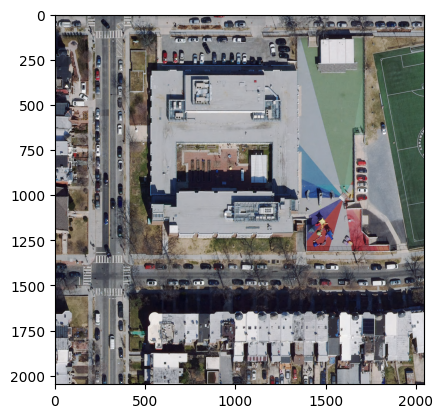

In [47]:
import rasterio
import rasterio.windows
import matplotlib.pyplot as plt
import numpy as np

image_path = '../data/OpenDataDC_Orthophoto_2021_JPEG2000/DCOCTO-2021.jp2'
raster_src = rasterio.open(image_path)

tile_window = rasterio.windows.Window(100000,100000,2048,2048)
im = raster_src.read([1,2,3], window=tile_window)
im = np.transpose(im, (1, 2, 0))
im.shape
plt.imshow(im)

In [52]:
rasterio.windows.bounds(tile_window, [0.08, 0.0, 389400.0,
        0.0, -0.08, 148200.0])

TypeError: can't multiply sequence by non-int of type 'tuple'

# TAKE 4

In [3]:
import rasterio
import rasterio.features
import rasterio.mask
import geopandas as gpd

image_path = '../data/OpenDataDC_Orthophoto_2021_JPEG2000/DCOCTO-2021.jp2'
dataset = rasterio.open(image_path)

# Open the GeoJSON file
geojson_file = '../data/RoadsRep.geojson'
geojson_data = gpd.read_file(geojson_file)

# Iterate over the image tiles
for block_index, window in dataset.block_windows(1):
    # Read the tile block
    tile = dataset.read(window=window)

    # Extract the subset of the GeoJSON data that intersects with the tile window
    tile_geojson = gpd.overlay(geojson_data['geometry'][0], window, how='intersection')

    # Create a pixel mask for the tile
    mask = rasterio.features.geometry_mask(tile_geojson.geometry,
                                           out_shape=(window.height, window.width),
                                           transform=window.transform,
                                           invert=False)

    # Write the tile and mask to new files
    tile_output_file = f'../data/tiles/tile_{block_index:0d5}.tif'
    mask_output_file = f'../data/tiles/mask_{block_index:0d5}.tif'

    # Update the image profile with the window transform and dimensions
    image_profile.update({
        'transform': window.transform,
        'width': window.width,
        'height': window.height
    })

    # Write the tile to a new file
    with rasterio.open(tile_output_file, 'w', **image_profile) as tile_dataset:
        tile_dataset.write(tile)

    # Write the mask to a new file
    with rasterio.open(mask_output_file, 'w', **image_profile) as mask_dataset:
        mask_dataset.write(mask.astype(rasterio.uint8), indexes=1)
        
    print(f'Written files with inted {block_index}.')


AttributeError: 'Polygon' object has no attribute 'crs'

# TAKE X+1

In [5]:
import rasterio
src = rasterio.open('../data/OpenDataDC_Orthophoto_2021_JPEG2000/DCOCTO-2021.jp2')
print(src.height, src.width, src.transform, src.crs)

300000 240000 | 0.08, 0.00, 389400.00|
| 0.00,-0.08, 148200.00|
| 0.00, 0.00, 1.00| EPSG:26985


In [7]:
import geopandas as gpd
geo = gpd.read_file('../data/RoadsRep.geojson')

In [24]:
for index, row in geo.iterrows():
    print(geo.iloc[index]['geometry'])
    break

POLYGON ((393327.4639941006 140176.9989630215, 393325.57499371195 140177.0269629801, 393325.4939937013 140177.0279629836, 393324.92699358624 140177.09696298, 393324.4749934845 140177.51796305782, 393324.0569933835 140178.01696315347, 393323.86699332687 140178.91296332565, 393323.8489934255 140174.4519624233, 393323.83599349234 140171.172961756, 393324.1769935585 140171.57996184748, 393324.6419936417 140171.86196191344, 393325.6179938346 140172.2449620135, 393325.8909938899 140172.22996201654, 393327.64999424515 140172.12896203488, 393335.263995785 140172.11896220263, 393347.33899822884 140172.04396246292, 393355.8149999359 140172.1559626783, 393358.172000413 140172.14596272848, 393365.07400180784 140172.2839629139, 393366.2400020434 140172.3249629489, 393374.15600363765 140172.25496310904, 393380.93500501325 140172.3069632743, 393386.245006079 140172.4119634172, 393399.8010088177 140172.57396375548, 393400.2530089094 140172.5789637658, 393421.63201324304 140172.01196413324, 393441.5630

In [44]:
def generate_polygon(bbox):
    """
    Generates a list of coordinates: [[x1,y1],[x2,y2],[x3,y3],[x4,y4],[x1,y1]]
    """
    return [[bbox[0],bbox[1]],
             [bbox[2],bbox[1]],
             [bbox[2],bbox[3]],
             [bbox[0],bbox[3]],
             [bbox[0],bbox[1]]]

In [62]:
from rasterio.windows import Window
from rasterio.coords import BoundingBox
import rasterio.windows as windows
from shapely.geometry import Polygon
from rasterio.features import rasterize

tile_size = 2048
src.shape
vertical_steps = src.shape[0] // tile_size
horizontal_steps = src.shape[1] // tile_size

col_offset = 100000
row_offset = 100000
for hstep in range(horizontal_steps):
    for vstep in range(vertical_steps):
        
        window = Window(col_offset, row_offset, tile_size, tile_size)
        bbox = windows.bounds(window, src.transform)
        
        cropped_polygons = []
        pol_bbox = gpd.GeoDataFrame(gpd.GeoSeries(Polygon(generate_polygon(bbox))), columns=['geometry'], crs=src.crs)
        tile_polygons = gpd.overlay(pol_bbox, geo, how='intersection')
        if not tile_polygons.empty:
            print(tile_polygons)
            for index, polygon in tile_polygons.iterrows():
                print(polygon)
        row_offset += tile_size
    
    col_offset += tile_size
        
        

   FEATURECODE   DESCRIPTION               CAPTUREYEAR CAPTUREACTION   
0         1060         Alley 2019-04-23 00:00:00+00:00             E  \
1         1050          Road 2021-03-11 00:00:00+00:00             U   
2         1070   Parking Lot 2015-04-24 00:00:00+00:00             E   
3         1050          Road 2015-04-24 00:00:00+00:00             E   
4         1050          Road 2015-04-24 00:00:00+00:00             E   
5         1050          Road 2015-04-24 00:00:00+00:00             E   
6         1050          Road 2015-04-24 00:00:00+00:00             E   
7         1090  Intersection 2015-04-24 00:00:00+00:00             E   
8         1050          Road 2015-04-24 00:00:00+00:00             E   
9         1090  Intersection 2015-04-24 00:00:00+00:00             E   

   DCGIS.RoadPly.AREA         GIS_ID  OBJECTID   
0                   0  RoadPly_27251     27251  \
1                   0  RoadPly_27405     27405   
2                   0  RoadPly_29552     29552   
3      

KeyboardInterrupt: 